# Vehicle Detection & Tracking

The task in this project is to detect and track vehicles in images and videos.

To do this, we have to decide which features we'd like to extract out of the input images. Next, we have to train a classifier. Eventually, we have to test the algorithm on input images and video streams.

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Download libraries

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Import Data

Images for training the classifier are divided up into vehicles & non-vehicles, and can be found in the folders `dataset_vehicles` and `dataset_non_vehicles`.

Images used for testing images can be found in the folder `test_images`.

Let's load them all.

Number of car images:  8792
Number of not-car images:  8968
Image shape:  (64, 64, 3)
Image data type:  <class 'numpy.ndarray'> ,  float32


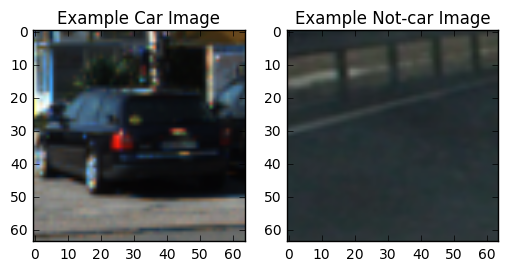

In [4]:
# Import all image paths for the images used to train the classifier
car_paths = glob.glob('dataset_vehicles/*/*.png')
not_car_paths = glob.glob('dataset_non_vehicles/*/*.png')
print('Number of car images: ', len(car_paths))
print('Number of not-car images: ', len(not_car_paths))
example_image = mpimg.imread(car_paths[0])
print('Image shape: ', example_image.shape)
print('Image data type: ', type(example_image), ", ", example_image.dtype)

# Import all image paths for the images to test your classifier on
test_paths = glob.glob('test_images/*.jpg')

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car_paths))
notcar_ind = np.random.randint(0, len(not_car_paths))
    
# Read in car / not-car images
car_image = mpimg.imread(car_paths[car_ind])
notcar_image = mpimg.imread(not_car_paths[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## Feature Extraction: Perform a Histogram of Oriented Gradients (HOG)

* Implement helper functions to extract HOG features from images
* Test it on example images

In [5]:
# Function returns HOG features and visualization
# orient: Number of orientation bins
# pix_per_cell: (2-tuple, (int, int)). Size of a cell (in pixels).
# cell_per_block: (2-tuple, (int, int)). Number of cells in each block.
# vis: bool. Return an image of the HOG?
# feature_vec: bool. Return the data as a feature vector by calling .ravel() on it?

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        visualise=vis, feature_vector=feature_vec)
        return features

(64, 64)


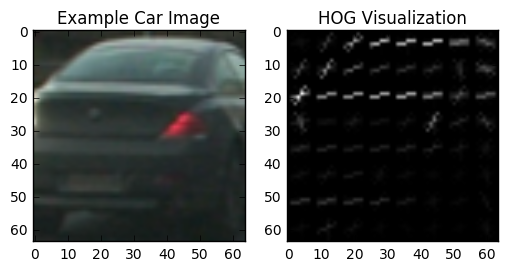

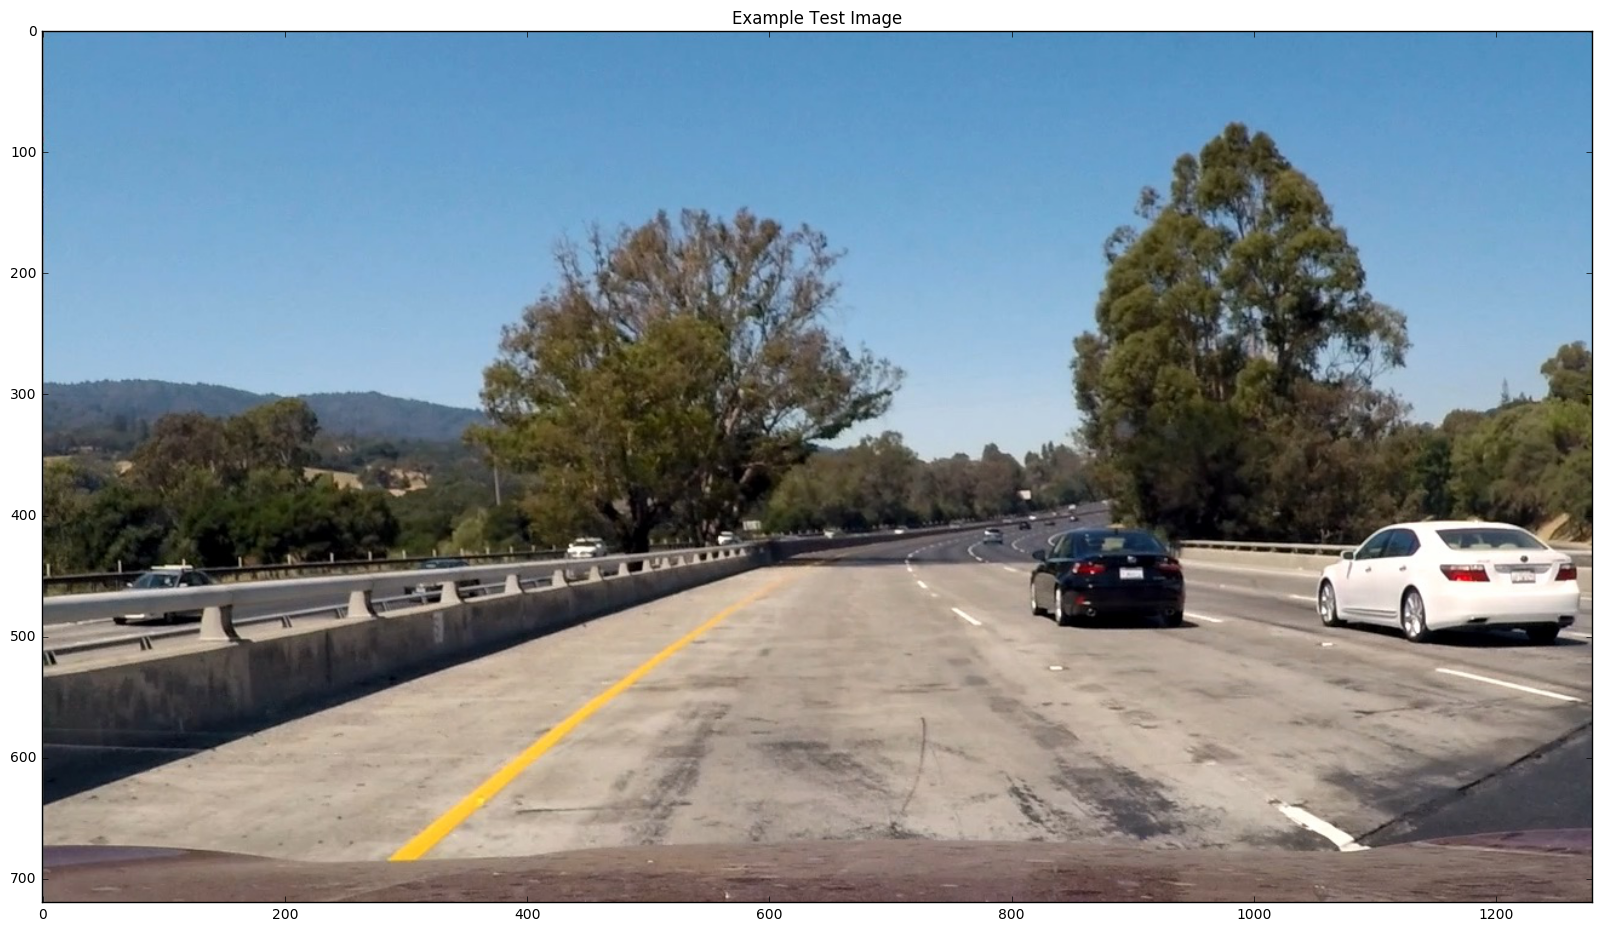

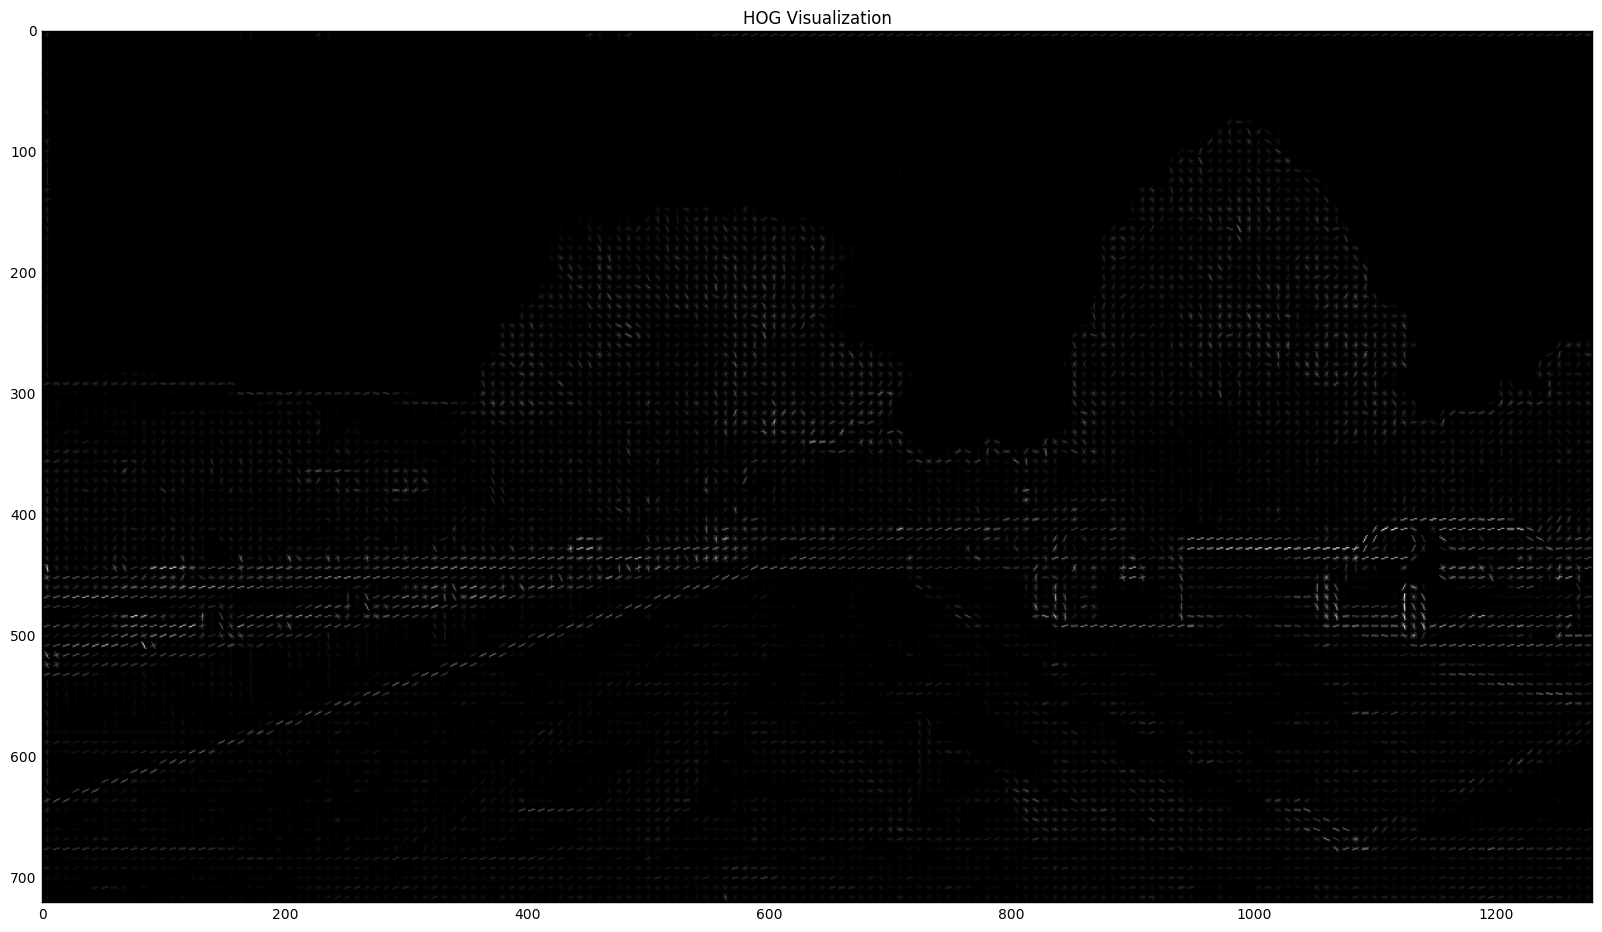

In [6]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_paths))
# Read in the image. Let's work with values between 0 to 255
image = mpimg.imread(car_paths[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
print(gray.shape)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Get the HOG features and visualization
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

# Test it on a test image
image = mpimg.imread(test_paths[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Get the HOG features and visualization
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize = (20, 20))
plt.imshow(image)
plt.title('Example Test Image')
fig = plt.figure(figsize = (20, 20))
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

If you look closely, you can recognize the cars in the HOG visualization! :D

## Feature Extraction: other color spaces

* Let's see how HOG works for other color spaces than RGB (e.g. HSV, LUV, HLS, YUV, YCrCb)
* To do that, let's define a new function

In [22]:
# Define a function to extract features from a list of images
# Have this function call get_hog_features()
def extract_features(img_files, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in img_files:
        # Read in each one by one
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            else:
                print('Given image space is not defined.')
        else: 
            img = np.uint8(img*255)
            feature_image = np.copy(img)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


There are a lot of parameters to tweak to see which ones result in the best accuracy. Optimally, we'd like to plot the training accuracy vs. test accuracy - but let's just look at the test accuracy here.

Let's do a grid search over: 
* all color spaces: RGB, HSV, LUV, YUV, YCrCb
* orientations: 6, 9, 12
* pix_per_cell: 4, 8, 16
* cell_per_block: 2, 4

Let's not change these parameters:
* hog_channel = "ALL"

Kedar: 16 pixels per cell, YUV color space, 4 cells per block, .5 overlap, HOG on all 3 channels

In [14]:
# Apply the HOG feature extraction to the data
# Let's do a grid search on the parameters:

# Reduce the sample size because HOG features are slow to compute
# Which is not good for grid search!
sample_size = 500
car_paths_shuffled = shuffle(car_paths)
not_car_paths_shuffled = shuffle(not_car_paths)
car_paths_subset = car_paths_shuffled[0:sample_size]
not_car_paths_subset = not_car_paths_shuffled[0:sample_size]

colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
# hog_channel can be 0, 1, 2, or "ALL" meaning that you extract HOG features
# from the first, second, third or all color channels, respectively
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

for colorspace in ['RGB', 'HSV', 'LUV', 'YUV', 'YCrCb']:
    for orient in [6, 9, 12]:
        for pix_per_cell in [4, 8, 16]:
            for cell_per_block in [2, 4]:

                # Extract features from images with and without cars.
                car_features = extract_features(car_paths_subset, cspace=colorspace, orient=orient, 
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel)
                notcar_features = extract_features(not_car_paths_subset, cspace=colorspace, orient=orient, 
                                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                    hog_channel=hog_channel)

                # Create an array stack of feature vectors
                X = np.vstack((car_features, notcar_features)).astype(np.float64)
                # Fit a per-column scaler
                X_scaler = StandardScaler().fit(X)
                # Apply the scaler to X
                scaled_X = X_scaler.transform(X)

                # Define the labels vector
                y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

                # Split up data into randomized training and test sets
                rand_state = np.random.randint(0, 100)
                X_train, X_test, y_train, y_test = train_test_split(
                    scaled_X, y, test_size=0.2, random_state=rand_state)

                print('Using:',orient,'orientations',pix_per_cell,
                    'pixels per cell and', cell_per_block,'cells per block')
                print('Feature vector length:', len(X_train[0]))
                # Use a linear SVC 
                svc = LinearSVC()
                # Check the training time for the SVC
                t=time.time()
                svc.fit(X_train, y_train)
                t2 = time.time()
                print(round(t2-t, 2), 'Seconds to train SVC...')
                # Check the score of the SVC
                print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
                # Check the prediction time for a single sample
                t=time.time()
                n_predict = 10
                print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
                print('For these',n_predict, 'labels: ', y_test[0:n_predict])
                t2 = time.time()
                print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
                print()

Using: 6 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 16200
0.72 Seconds to train SVC...
Test Accuracy of SVC =  0.89
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
0.00341 Seconds to predict 10 labels with SVC

Using: 6 orientations 4 pixels per cell and 4 cells per block
Feature vector length: 48672
4.02 Seconds to train SVC...
Test Accuracy of SVC =  0.95
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
0.00398 Seconds to predict 10 labels with SVC

Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3528
0.36 Seconds to train SVC...
Test Accuracy of SVC =  0.925
My SVC predicts:  [ 1.  0.  0.  0.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  1.  1.  0.  0.  1.]
0.00393 Seconds to predict 10 labels with SVC

Using: 6 orientations 8 pixels per cell 

In [14]:
# Split the data before shuffling it, that'll help to avoid overfitting
# Explanation: If you shuffle before splitting the dataset into training & validation sets,
# you will have very similar data in both sets, which will set you up for overfitting.
print('len(car_paths): ', len(car_paths))
print('len(not_car_paths): ', len(not_car_paths))

num_val_set = int(len(car_paths) * 0.2)
num_train_set = int(len(car_paths) - num_val_set)
print("num_val_set: ", num_val_set)
print("num_train_set: ", num_train_set)

train_set_cars = car_paths[:num_train_set]
train_set_not_cars = not_car_paths[:num_train_set]
val_set_cars = car_paths[num_train_set:]
val_set_not_cars = not_car_paths[num_train_set:]

len(car_paths):  8792
len(not_car_paths):  8968
num_val_set:  1758
num_train_set:  7034


Let's try the 'best' parameter combinations and let's train the model properly.

What I found to be the 'best' parameter combination in my grid search could be those three:

* HSV, orient: 12, pix_per_cell: 4, cell_per_block: 4 (97344 features)
* YUV, orient: 12, pix_per_cell: 4, cell_per_block: 4 (97344 features)
* YCrCb, orient: 12, pix_per_cell: 8, cell_per_block: 2 (47056 features)


In [23]:
# Apply the HOG feature extraction to the data
colorspace = 'LUV'
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"

train_set_cars = car_paths[:num_train_set]
train_set_not_cars = not_car_paths[:num_train_set]
val_set_cars = car_paths[num_train_set:]
val_set_not_cars = not_car_paths[num_train_set:]

# Extract features from images with and without cars.
car_features_train = extract_features(train_set_cars, cspace=colorspace, orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel)
print('done with calculating car-train features')
notcar_features_train = extract_features(train_set_not_cars, cspace=colorspace, orient=orient, 
                                         pix_per_cell=pix_per_cell, 
                                         cell_per_block=cell_per_block, 
                                         hog_channel=hog_channel)
print('done with calculating notcar-train features')
car_features_val = extract_features(val_set_cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
print('done with calculating car-val features')
notcar_features_val = extract_features(val_set_not_cars, cspace=colorspace, orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)
print('done with calculating notcar-val features')

done with calculating car-train features
done with calculating notcar-train features
done with calculating car-val features
done with calculating notcar-val features


In [24]:
print('len(car_features_train): ', len(car_features_train))
print('len(notcar_features_train): ', len(notcar_features_train))
print('len(car_features_val): ', len(car_features_val))
print('len(notcar_features_val): ', len(notcar_features_val))

# Create an array stack of feature vectors
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)
X_val = np.vstack((car_features_val, notcar_features_val)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_val
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
print('done transforming data')

# Define the labels vector
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_val = np.hstack((np.ones(len(car_features_val)), np.zeros(len(notcar_features_val))))
print('done preparing label vector')

len(car_features_train):  7034
len(notcar_features_train):  7034
len(car_features_val):  1758
len(notcar_features_val):  1934
done transforming data
done preparing label vector


In [25]:
# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)
print('done splitting data')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train_shuffled[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train_shuffled, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

done splitting data
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
39.31 Seconds to train SVC...


In [27]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_val_shuffled, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_val_shuffled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print()

Test Accuracy of SVC =  0.9347
My SVC predicts:  [ 1.  0.  1.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
0.00754 Seconds to predict 10 labels with SVC



In [28]:
# YCrCb, orient: 12, pix_per_cell: 8, cell_per_block: 2 (47056 features)
colorspace = 'YCrCb'
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)
print('done splitting data')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train_shuffled[0]))
# Use a linear SVC 
svc2 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc2.fit(X_train_shuffled, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

done splitting data
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
36.67 Seconds to train SVC...


In [29]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc2.score(X_val_shuffled, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc2.predict(X_val_shuffled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print()

Test Accuracy of SVC =  0.9347
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
0.03927 Seconds to predict 10 labels with SVC



In [30]:
# HSV, orient: 12, pix_per_cell: 4, cell_per_block: 4 (97344 features)
colorspace = 'HSV'
orient = 12
pix_per_cell = 4
cell_per_block = 4
hog_channel = "ALL"
# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(scaled_X_train, y_train)
X_val_shuffled, y_val_shuffled = shuffle(scaled_X_val, y_val)
print('done splitting data')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train_shuffled[0]))
# Use a linear SVC 
svc3 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc3.fit(X_train_shuffled, y_train_shuffled)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

done splitting data
Using: 12 orientations 4 pixels per cell and 4 cells per block
Feature vector length: 7056
33.22 Seconds to train SVC...


In [31]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc3.score(X_val_shuffled, y_val_shuffled), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc3.predict(X_val_shuffled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val_shuffled[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print()

Test Accuracy of SVC =  0.9347
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  0.  1.  0.]
0.00386 Seconds to predict 10 labels with SVC



## Combine all 3 feature extractions into one function

## Train a linear Support Vector Machine (SVM) classifier

* Train a classifier to detect cars

## Sliding Window Search

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images

## Apply pipeline on a video stream

* Run your pipeline on a video stream
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.